# setup and configuration

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle

# --- Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8-darkgrid')

# --- Random Seed ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

# --- Model/Metrics ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- ML Models ---
import lightgbm as lgb
import xgboost as xgb

# --- Tuning ---
try:
    import optuna
except ImportError:
    print("Installing Optuna...")
    !pip install optuna -q
    import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Feature Engineering Helpers ---
try:
    from pyzipcode import ZipCodeDatabase
except ImportError:
    print("Installing pyzipcode...")
    !pip install pyzipcode -q
    from pyzipcode import ZipCodeDatabase

print("\n✓ Setup complete. All libraries loaded.")




✓ Setup complete. All libraries loaded.


# data loading


In [24]:
# --- Helper ---
# This is the state extractor function from Carol's notebook.
# We define it here so it's available for the feature engineering step.
zcdb = ZipCodeDatabase()
def get_state(zip_code):
    """Converts a zip code to a 2-letter state, handling errors."""
    try:
        # Handle NaN/null values
        if pd.isna(zip_code):
            return 'Unknown'
        # Format zip code to 5 digits, handling floats/ints
        zip_code_str = str(int(float(zip_code))).zfill(5)
        return zcdb[zip_code_str].state
    except (ValueError, KeyError, AttributeError, TypeError):
        return 'Unknown' # Use 'Unknown' for NaNs or invalid zips

print("✓ State feature helper created.")


# --- Load Data ---
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import files
    try:
        # Try loading directly if files are already in the environment
        train_df = pd.read_csv('Training_TriGuard.csv')
        test_df = pd.read_csv('Testing_TriGuard.csv')
        print("✓ Files loaded from local environment.")
    except FileNotFoundError:
        print("Please upload Training_TriGuard.csv:")
        uploaded_train = files.upload()
        train_file = list(uploaded_train.keys())[0]
        train_df = pd.read_csv(train_file)

        print("\nPlease upload Testing_TriGuard.csv:")
        uploaded_test = files.upload()
        test_file = list(uploaded_test.keys())[0]
        test_df = pd.read_csv(test_file)
        print("✓ Files uploaded successfully.")
else:
    # Local environment - adjust paths as needed
    import os
    # Try common paths
    possible_paths = [
        'Training_TriGuard.csv',
        'data/Training_TriGuard.csv',
        '../Training_TriGuard.csv',
        './Training_TriGuard.csv'
    ]

    train_path = None
    test_path = None

    for path in possible_paths:
        if os.path.exists(path):
            train_path = path
            test_path = path.replace('Training', 'Testing')
            if os.path.exists(test_path):
                break

    if train_path and test_path:
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        print(f"✓ Files loaded from: {train_path} and {test_path}")
    else:
        # Prompt for file paths
        train_path = input("Enter path to Training_TriGuard.csv: ").strip()
        test_path = input("Enter path to Testing_TriGuard.csv: ").strip()
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        print("✓ Files loaded successfully.")

# --- Critical Cleaning ---
# Drop the 2 rows with NaN target variable
initial_train_count = len(train_df)
train_df = train_df.dropna(subset=['subrogation'])
print(f"\nCleaned training data: Removed {initial_train_count - len(train_df)} rows with NaN target.")

# Cast target to int
train_df['subrogation'] = train_df['subrogation'].astype(int)

# --- Review Data ---
print(f"\n✓ Train shape: {train_df.shape}")
print(f"✓ Test shape: {test_df.shape}")
print(f"\nTarget distribution (after cleaning):")
print(train_df['subrogation'].value_counts(normalize=True).to_string())

# Save test IDs for final submission
test_ids = test_df['claim_number'].copy()



✓ State feature helper created.
✓ Files loaded from local environment.

Cleaned training data: Removed 2 rows with NaN target.

✓ Train shape: (17999, 29)
✓ Test shape: (12000, 28)

Target distribution (after cleaning):
subrogation
0   0.771
1   0.229


# feature engineering


In [33]:
print("="*80)
print("Defining the Combined Feature Engineering Function...")

# Note: get_state function is already defined in Cell 3
# We use it directly here

def feature_engineer(df):
    """Applies all 170+ features to a train or test dataframe."""
    df_fe = df.copy()

    # ========================================================================\
    # TEMPORAL FEATURES (Cecilia + Carol)
    # ========================================================================\
    df_fe['claim_date'] = pd.to_datetime(df_fe['claim_date'], errors='coerce')
    df_fe['claim_year'] = df_fe['claim_date'].dt.year
    df_fe['claim_month'] = df_fe['claim_date'].dt.month
    df_fe['claim_day'] = df_fe['claim_date'].dt.day
    df_fe['claim_quarter'] = df_fe['claim_date'].dt.quarter
    df_fe['claim_dayofweek'] = df_fe['claim_date'].dt.dayofweek
    df_fe['is_weekend'] = (df_fe['claim_dayofweek'] >= 5).astype(int)
    df_fe['is_monday'] = (df_fe['claim_dayofweek'] == 0).astype(int)
    df_fe['is_friday'] = (df_fe['claim_dayofweek'] == 4).astype(int)
    df_fe['is_q4'] = (df_fe['claim_quarter'] == 4).astype(int)

    # Carol's 'season' feature
    season_map = {
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall',
        12: 'Winter', 1: 'Winter', 2: 'Winter'
    }
    df_fe['season'] = df_fe['claim_month'].map(season_map).fillna('Unknown')

    # ========================================================================\
    # DATA CLEANING (Cecilia)
    # ========================================================================\
    # Clean invalid birth years
    df_fe.loc[(df_fe['year_of_born'] < 1900) | (df_fe['year_of_born'] > 2025), 'year_of_born'] = np.nan
    # Clean vehicle years from the future (relative to claim year)
    future_mask = df_fe['vehicle_made_year'] > df_fe['claim_year']
    df_fe.loc[future_mask, 'vehicle_made_year'] = np.nan

    # ========================================================================\
    # GEOGRAPHICAL FEATURE (Carol)
    # ========================================================================\
    df_fe['state'] = df_fe['zip_code'].apply(get_state)

    # ========================================================================\
    # TIER 1: CRITICAL INTERACTION FEATURES (Cecilia)
    # ========================================================================\
    df_fe['witness_binary'] = (df_fe['witness_present_ind'] == 'Y').astype(int)
    df_fe['police_binary'] = df_fe['policy_report_filed_ind']
    df_fe['multicar_binary'] = df_fe['accident_type'].isin(['multi_vehicle_clear', 'multi_vehicle_unclear']).astype(int)
    df_fe['highrisk_site_binary'] = df_fe['accident_site'].isin(['Highway/Intersection', 'Local']).astype(int)

    df_fe['liab_x_witness'] = df_fe['liab_prct'] * df_fe['witness_binary']
    df_fe['liab_x_police'] = df_fe['liab_prct'] * df_fe['police_binary']
    df_fe['liab_x_multicar'] = df_fe['liab_prct'] * df_fe['multicar_binary']
    df_fe['liab_x_highrisk_site'] = df_fe['liab_prct'] * df_fe['highrisk_site_binary']
    df_fe['liab_x_evidence'] = df_fe['liab_prct'] * (df_fe['witness_binary'] + df_fe['police_binary'])
    df_fe['witness_x_police'] = df_fe['witness_binary'] * df_fe['police_binary']
    df_fe['witness_x_multicar'] = df_fe['witness_binary'] * df_fe['multicar_binary']
    df_fe['police_x_multicar'] = df_fe['police_binary'] * df_fe['multicar_binary']
    df_fe['multicar_x_highrisk'] = df_fe['multicar_binary'] * df_fe['highrisk_site_binary']

    # ========================================================================\
    # TIER 2: POLYNOMIAL & LOG FEATURES (Cecilia + Carol)
    # ========================================================================\
    # Cecilia's Polynomials
    df_fe['liab_prct_squared'] = df_fe['liab_prct'] ** 2
    df_fe['liab_prct_cubed'] = df_fe['liab_prct'] ** 3
    df_fe['liab_prct_sqrt'] = np.sqrt(df_fe['liab_prct'])
    df_fe['liab_prct_log'] = np.log1p(df_fe['liab_prct'])
    df_fe['liab_inverse'] = 100 - df_fe['liab_prct']
    df_fe['liab_inverse_squared'] = (100 - df_fe['liab_prct']) ** 2

    # Carol's Log Transforms
    df_fe['log_claim_est_payout'] = np.log1p(df_fe['claim_est_payout'])
    df_fe['log_vehicle_mileage'] = np.log1p(df_fe['vehicle_mileage'])
    df_fe['log_vehicle_price'] = np.log1p(df_fe['vehicle_price'])

    # ========================================================================\
    # ACCIDENT TYPE FEATURES (Cecilia)
    # ========================================================================\
    df_fe['is_multi_vehicle_clear'] = (df_fe['accident_type'] == 'multi_vehicle_clear').astype(int)
    df_fe['is_multi_vehicle_unclear'] = (df_fe['accident_type'] == 'multi_vehicle_unclear').astype(int)
    df_fe['is_single_car'] = (df_fe['accident_type'] == 'single_car').astype(int)
    df_fe['has_recovery_target'] = df_fe['multicar_binary']
    df_fe['recovery_case_clarity'] = 0
    df_fe.loc[df_fe['is_multi_vehicle_clear'] == 1, 'recovery_case_clarity'] = 3
    df_fe.loc[df_fe['is_multi_vehicle_unclear'] == 1, 'recovery_case_clarity'] = 1

    # ========================================================================\
    # LIABILITY BUCKETS (Cecilia)
    # ========================================================================\
    df_fe['liab_under_10'] = (df_fe['liab_prct'] < 10).astype(int)
    df_fe['liab_10_to_15'] = ((df_fe['liab_prct'] >= 10) & (df_fe['liab_prct'] < 15)).astype(int)
    df_fe['liab_15_to_20'] = ((df_fe['liab_prct'] >= 15) & (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['liab_20_to_25'] = ((df_fe['liab_prct'] >= 20) & (df_fe['liab_prct'] < 25)).astype(int)
    df_fe['liab_25_to_30'] = ((df_fe['liab_prct'] >= 25) & (df_fe['liab_prct'] < 30)).astype(int)
    df_fe['liab_30_to_35'] = ((df_fe['liab_prct'] >= 30) & (df_fe['liab_prct'] < 35)).astype(int)
    df_fe['liab_35_to_40'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 40)).astype(int)
    df_fe['liab_40_to_50'] = ((df_fe['liab_prct'] >= 40) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['liab_over_50'] = (df_fe['liab_prct'] >= 50).astype(int)
    df_fe['not_at_fault'] = df_fe['liab_under_10']
    df_fe['minimal_fault'] = (df_fe['liab_prct'] < 25).astype(int)
    df_fe['low_fault'] = (df_fe['liab_prct'] < 35).astype(int)
    df_fe['shared_fault'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['high_fault'] = (df_fe['liab_prct'] >= 50).astype(int)

    # ========================================================================\
    # EVIDENCE QUALITY FEATURES (Cecilia)
    # ========================================================================\
    df_fe['witness_present'] = df_fe['witness_binary']
    df_fe['police_report'] = df_fe['police_binary']
    df_fe['evidence_none'] = ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 0)).astype(int)
    df_fe['evidence_weak'] = (((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 0)) |
                           ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 1))).astype(int)
    df_fe['evidence_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1)).astype(int)
    df_fe['evidence_very_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1) &
                                  (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['evidence_score'] = df_fe['witness_present'] + df_fe['police_report']

    # ========================================================================\
    # ACCIDENT SITE FEATURES (Cecilia)
    # ========================================================================\
    df_fe['high_risk_site'] = df_fe['highrisk_site_binary']
    df_fe['parking_accident'] = (df_fe['accident_site'] == 'Parking Area').astype(int)
    df_fe['unknown_site'] = (df_fe['accident_site'] == 'Unknown').astype(int)
    df_fe['highway_accident'] = (df_fe['accident_site'] == 'Highway/Intersection').astype(int)
    df_fe['local_accident'] = (df_fe['accident_site'] == 'Local').astype(int)

    # ========================================================================\
    # DRIVER AGE & EXPERIENCE (Cecilia + Carol)
    # ========================================================================\
    df_fe['driver_age'] = df_fe['claim_year'] - df_fe['year_of_born']
    df_fe.loc[(df_fe['driver_age'] < 16) | (df_fe['driver_age'] > 100), 'driver_age'] = np.nan

    df_fe['young_driver'] = ((df_fe['driver_age'] >= 16) & (df_fe['driver_age'] <= 25)).astype(int)
    df_fe['prime_driver'] = ((df_fe['driver_age'] > 25) & (df_fe['driver_age'] <= 45)).astype(int)
    df_fe['middle_age_driver'] = ((df_fe['driver_age'] > 45) & (df_fe['driver_age'] <= 65)).astype(int)
    df_fe['senior_driver'] = (df_fe['driver_age'] > 65).astype(int)

    # Carol's version of driving_experience (handles negatives)
    df_fe['driving_experience'] = (df_fe['driver_age'] - df_fe['age_of_DL']).clip(lower=0)
    df_fe.loc[df_fe['driving_experience'] < 0, 'driving_experience'] = np.nan

    df_fe['novice_driver'] = (df_fe['driving_experience'] < 3).astype(int)
    df_fe['experienced_driver'] = ((df_fe['driving_experience'] >= 3) & (df_fe['driving_experience'] <= 10)).astype(int)
    df_fe['veteran_driver'] = (df_fe['driving_experience'] > 10).astype(int)

    # Carol's Interaction
    df_fe['experience_x_safety'] = df_fe['driving_experience'] * df_fe['safety_rating']


    # ========================================================================\
    # VEHICLE FEATURES (Cecilia)
    # ========================================================================\
    df_fe['vehicle_age'] = df_fe['claim_year'] - df_fe['vehicle_made_year']
    df_fe['new_vehicle'] = (df_fe['vehicle_age'] <= 2).astype(int)
    df_fe['mid_age_vehicle'] = ((df_fe['vehicle_age'] > 2) & (df_fe['vehicle_age'] <= 7)).astype(int)
    df_fe['old_vehicle'] = (df_fe['vehicle_age'] > 10).astype(int)

    df_fe['luxury_vehicle'] = (df_fe['vehicle_price'] > 50000).astype(int)
    df_fe['mid_price_vehicle'] = ((df_fe['vehicle_price'] >= 20000) & (df_fe['vehicle_price'] <= 50000)).astype(int)
    df_fe['economy_vehicle'] = (df_fe['vehicle_price'] < 20000).astype(int)

    df_fe['heavy_vehicle'] = (df_fe['vehicle_weight'] > 30000).astype(int)
    df_fe['light_vehicle'] = (df_fe['vehicle_weight'] < 15000).astype(int)

    df_fe['is_large_vehicle'] = (df_fe['vehicle_category'] == 'Large').astype(int)
    df_fe['is_compact_vehicle'] = (df_fe['vehicle_category'] == 'Compact').astype(int)

    # ========================================================================\
    # CLAIM CHARACTERISTICS (Cecilia + Carol)
    # ========================================================================\
    df_fe['high_mileage'] = (df_fe['vehicle_mileage'] > 100000).astype(int)
    df_fe['low_mileage'] = (df_fe['vehicle_mileage'] < 50000).astype(int)
    df_fe['very_high_mileage'] = (df_fe['vehicle_mileage'] > 150000).astype(int)

    df_fe['frequent_claimer'] = (df_fe['past_num_of_claims'] > 5).astype(int)
    df_fe['moderate_claimer'] = ((df_fe['past_num_of_claims'] >= 1) & (df_fe['past_num_of_claims'] <= 5)).astype(int)
    df_fe['first_time_claimer'] = (df_fe['past_num_of_claims'] == 0).astype(int)
    df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)

    df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
    df_fe['medium_payout'] = ((df_fe['claim_est_payout'] >= 2000) & (df_fe['claim_est_payout'] <= 5000)).astype(int)
    df_fe['small_payout'] = (df_fe['claim_est_payout'] < 2000).astype(int)
    df_fe['very_large_payout'] = (df_fe['claim_est_payout'] > 8000).astype(int)

    # Carol's Interaction
    df_fe['safety_x_prior_claims'] = df_fe['safety_rating'] / (1 + df_fe['past_num_of_claims'])

    # ========================================================================\
    # TIER 4: RATIO FEATURES (Cecilia + Carol)
    # ========================================================================\
    df_fe['payout_to_price_ratio'] = df_fe['claim_est_payout'] / (df_fe['vehicle_price'] + 1)
    df_fe['severe_damage'] = (df_fe['payout_to_price_ratio'] > 0.3).astype(int)
    df_fe['moderate_damage'] = ((df_fe['payout_to_price_ratio'] >= 0.1) & (df_fe['payout_to_price_ratio'] <= 0.3)).astype(int)
    df_fe['minor_damage'] = (df_fe['payout_to_price_ratio'] < 0.1).astype(int)

    # Renamed this from Cecilia's 'income_to_price_ratio'
    df_fe['income_to_vehicle_price'] = df_fe['annual_income'] / (df_fe['vehicle_price'] + 1)
    df_fe['can_afford_vehicle'] = (df_fe['income_to_vehicle_price'] >= 0.5).astype(int)
    df_fe['expensive_for_income'] = (df_fe['income_to_vehicle_price'] < 0.3).astype(int)

    df_fe['mileage_per_year'] = df_fe['vehicle_mileage'] / (df_fe['vehicle_age'] + 1)
    df_fe['high_annual_mileage'] = (df_fe['mileage_per_year'] > 15000).astype(int)

    df_fe['claims_per_year_driving'] = df_fe['past_num_of_claims'] / (df_fe['driving_experience'] + 1)
    df_fe['claim_frequency_high'] = (df_fe['claims_per_year_driving'] > 0.5).astype(int)

    df_fe['safety_to_liability'] = df_fe['safety_rating'] / (df_fe['liab_prct'] + 1)
    df_fe['payout_to_income'] = df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)

    # ========================================================================\
    # POLICYHOLDER CHARACTERISTICS (Cecilia)
    # ========================================================================\
    df_fe['high_income'] = (df_fe['annual_income'] > 70000).astype(int)
    df_fe['mid_income'] = ((df_fe['annual_income'] >= 40000) & (df_fe['annual_income'] <= 70000)).astype(int)
    df_fe['low_income'] = (df_fe['annual_income'] < 40000).astype(int)
    df_fe['very_high_income'] = (df_fe['annual_income'] > 100000).astype(int)

    df_fe['high_safety_rating'] = (df_fe['safety_rating'] > 80).astype(int)
    df_fe['low_safety_rating'] = (df_fe['safety_rating'] < 60).astype(int)
    df_fe['very_high_safety'] = (df_fe['safety_rating'] > 90).astype(int)

    df_fe['contact_available'] = df_fe['email_or_tel_available']
    df_fe['has_education'] = df_fe['high_education_ind']
    df_fe['recent_move'] = df_fe['address_change_ind']
    df_fe['home_owner'] = (df_fe['living_status'] == 'Own').astype(int)
    df_fe['renter'] = (df_fe['living_status'] == 'Rent').astype(int)
    df_fe['female'] = (df_fe['gender'] == 'F').astype(int)

    # ========================================================================\
    # CHANNEL FEATURES (Cecilia)
    # ========================================================================\
    df_fe['via_broker'] = (df_fe['channel'] == 'Broker').astype(int)
    df_fe['via_online'] = (df_fe['channel'] == 'Online').astype(int)
    df_fe['via_phone'] = (df_fe['channel'] == 'Phone').astype(int)
    df_fe['in_network_repair'] = (df_fe['in_network_bodyshop'] == 'yes').astype(int)

    # ========================================================================\
    # COMPOSITE SCORES (Cecilia)
    # ========================================================================\
    liability_score = np.sqrt((100 - df_fe['liab_prct']) / 100.0)
    evidence_score = (df_fe['evidence_none'] * 0.0 + df_fe['evidence_weak'] * 0.4 +
                      df_fe['evidence_strong'] * 0.7 + df_fe['evidence_very_strong'] * 1.0)
    clarity_score = df_fe['recovery_case_clarity'] / 3.0
    site_score = df_fe['high_risk_site'] * 0.7 + (1 - df_fe['unknown_site']) * 0.3

    df_fe['recovery_feasibility_score'] = (0.35 * liability_score + 0.30 * df_fe['has_recovery_target'] +
                                         0.20 * evidence_score + 0.10 * clarity_score + 0.05 * site_score)

    # ========================================================================\
    # DOMAIN LOGIC FLAGS (Cecilia)
    # ========================================================================\
    df_fe['perfect_case'] = ((df_fe['liab_prct'] < 15) & (df_fe['witness_present'] == 1) &
                          (df_fe['police_report'] == 1) & (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['strong_case'] = ((df_fe['liab_prct'] < 25) & (df_fe['evidence_strong'] == 1) &
                         (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['good_case'] = ((df_fe['liab_prct'] < 35) & (df_fe['evidence_score'] >= 1) &
                       (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['weak_case'] = ((df_fe['liab_prct'] > 40) | (df_fe['is_single_car'] == 1) |
                       (df_fe['evidence_none'] == 1)).astype(int)
    df_fe['no_case'] = ((df_fe['liab_prct'] > 60) | ((df_fe['is_single_car'] == 1) & (df_fe['evidence_none'] == 1))).astype(int)
    df_fe['high_value_opportunity'] = ((df_fe['claim_est_payout'] > 3000) & (df_fe['liab_prct'] < 30) &
                                     (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['slam_dunk_case'] = ((df_fe['liab_prct'] < 10) & (df_fe['witness_present'] == 1) &
                            (df_fe['police_report'] == 1) & (df_fe['multicar_binary'] == 1) &
                            (df_fe['high_risk_site'] == 1)).astype(int)

    return df_fe

print("✓ Feature engineering function defined.")



Defining the Combined Feature Engineering Function...
✓ Feature engineering function defined.


# pre-modeling with target encoding


In [34]:
print("="*80)
print("Running Feature Engineering on train and test data...")
# Use train_df and test_df (from Chunk 3) instead of 'train' and 'test'
train_fe = feature_engineer(train_df)
test_fe = feature_engineer(test_df)
print("✓ Feature engineering complete.")

# --- 1. Define Categorical Feature Lists ---
# These are all the 'object' type features we created
features_to_target_encode = [
    'gender', 'living_status', 'claim_day_of_week', 'accident_site',
    'channel', 'vehicle_category', 'vehicle_color', 'accident_type',
    'in_network_bodyshop', 'season', 'state'
]
# We also include 'zip_code' which is numeric but high-cardinality
features_to_target_encode.append('zip_code')


# --- 2. Apply Target Encoding (for all non-binary categoricals) ---
print(f"\nApplying Smoothed Target Encoding to {len(features_to_target_encode)} features...")
global_mean = train_fe['subrogation'].mean()
categorical_features_for_lgbm = [] # This will store our new encoded col names

for col in features_to_target_encode:
    # Calculate mean subrogation rate per category from training data
    target_mean = train_fe.groupby(col)['subrogation'].mean()
    category_counts = train_fe.groupby(col).size()
    smoothing = 20  # A moderate smoothing factor

    # Calculate the smoothed mean
    smoothed_mean = (target_mean * category_counts + global_mean * smoothing) / (category_counts + smoothing)

    # Create the new target-encoded feature
    new_col_name = f'{col}_target_enc'
    train_fe[new_col_name] = train_fe[col].map(smoothed_mean)
    test_fe[new_col_name] = test_fe[col].map(smoothed_mean)

    # Fill any new NaNs in the test set (for categories not seen in train)
    test_fe[new_col_name] = test_fe[new_col_name].fillna(global_mean)

    # Add our new encoded feature to the list for LGBM
    categorical_features_for_lgbm.append(new_col_name)

print("✓ Target encoding complete.")


# --- 3. Create Final X, y, and X_test ---
y_all = train_fe['subrogation'].copy()

# Define all columns to drop for the final model
drop_cols = [
    'subrogation', 'claim_number', 'claim_date', 'year_of_born',
    'witness_present_ind', 'policy_report_filed_ind'
]
# Drop the original categorical columns that we just target-encoded
drop_cols.extend(features_to_target_encode)

feature_cols = [col for col in train_fe.columns if col not in drop_cols]
X_all = train_fe[feature_cols].copy()
X_test_all = test_fe[feature_cols].copy()


# --- 4. Apply Label Encoding (for Low-Cardinality & Binary) ---
# Find any remaining 'object' columns (there shouldn't be any, but just in case)
other_cat_cols = X_all.select_dtypes(include='object').columns.tolist()
if other_cat_cols:
    print(f"\nApplying Label Encoding to {len(other_cat_cols)} remaining features...")
    for col in other_cat_cols:
        le = LabelEncoder()
        all_values = pd.concat([X_all[col].astype(str), X_test_all[col].astype(str)]).unique()
        le.fit(all_values)
        X_all[col] = le.transform(X_all[col].astype(str))
        X_test_all[col] = le.transform(X_test_all[col].astype(str))
    print("✓ Label encoding complete.")
else:
    print("\n✓ No remaining 'object' columns to LabelEncode.")


# --- 5. Impute NaNs with Median ---
print("\nImputing NaN values with the median from the training data...")
X_all_median = X_all.median()
X_all = X_all.fillna(X_all_median)
X_test_all = X_test_all.fillna(X_all_median)
print("✓ NaN values imputed.")

# --- 6. Calculate scale_pos_weight ---
scale_pos_weight = (y_all == 0).sum() / (y_all == 1).sum()

# --- 7. Note: We don't specify categorical features for LightGBM ---
# LightGBM will auto-detect categorical features from the data types
# This matches your old working code pattern


print("\n" + "="*80)
print("PRE-MODELING COMPLETE")
print(f"✓ X_all shape: {X_all.shape}")
print(f"✓ y_all shape: {y_all.shape}")
print(f"✓ X_test_all shape: {X_test_all.shape}")
print(f"✓ Total features: {len(feature_cols)}")
print(f"✓ scale_pos_weight (for F1 score): {scale_pos_weight:.4f}")



Running Feature Engineering on train and test data...
✓ Feature engineering complete.

Applying Smoothed Target Encoding to 12 features...
✓ Target encoding complete.

✓ No remaining 'object' columns to LabelEncode.

Imputing NaN values with the median from the training data...
✓ NaN values imputed.

PRE-MODELING COMPLETE
✓ X_all shape: (17999, 158)
✓ y_all shape: (17999,)
✓ X_test_all shape: (12000, 158)
✓ Total features: 158
✓ scale_pos_weight (for F1 score): 3.3740


# training lightGBM model



In [35]:
print("="*80)
print("STEP 1: TESTING WITH FIXED HYPERPARAMETERS (70/30 SPLIT)")
print("="*80)

# --- 1. Create a stable 70/30 validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y_all
)

print(f"\nTrain: {X_train.shape}, Validation: {X_val.shape}")
print(f"Train target distribution:")
print(y_train.value_counts().to_dict())
print(f"\nVal target distribution:")
print(y_val.value_counts().to_dict())

# --- 2. Test with fixed hyperparameters first (like your old code) ---
print("\n" + "="*80)
print("Testing LightGBM with fixed hyperparameters...")
print("="*80)

lgb_fixed = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    num_leaves=50,
    scale_pos_weight=scale_pos_weight,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgb_fixed.fit(X_train, y_train)
val_preds_fixed = lgb_fixed.predict(X_val)
val_probas_fixed = lgb_fixed.predict_proba(X_val)[:, 1]

f1_fixed = f1_score(y_val, val_preds_fixed)
roc_fixed = roc_auc_score(y_val, val_probas_fixed)
pr_fixed = average_precision_score(y_val, val_probas_fixed)

print(f"\nFixed Hyperparameters Performance:")
print(f"F1 Score: {f1_fixed:.4f}")
print(f"ROC AUC: {roc_fixed:.4f}")
print(f"PR AUC: {pr_fixed:.4f}")
print(f"\nClassification Report:\n{classification_report(y_val, val_preds_fixed)}")

# --- 3. Optuna Hyperparameter Tuning (SIMPLE - like your old code) ---
print("\n" + "="*80)
print("STEP 2: OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*80)

# Define objective function with THRESHOLD OPTIMIZATION (critical for F1 maximization!)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # CRITICAL: Optimize threshold for F1 score (not just use 0.5)
    # This is the KEY to maximizing F1 for imbalanced data!
    pred_proba = model.predict_proba(X_val)[:, 1]

    # Test multiple thresholds to find optimal F1
    best_f1 = 0
    best_thresh = 0.5

    for thresh in np.arange(0.25, 0.76, 0.02):  # Test wide range of thresholds
        preds = (pred_proba >= thresh).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    return best_f1  # Return the best F1 found with optimal threshold

# Run optimization with MORE TRIALS for better results
print("\nRunning Optuna optimization (100 trials, ~10-15 minutes)...")
print("This will test 100 different parameter combinations with threshold optimization...")
print("⚠️  This takes longer but maximizes F1 score!\n")

study = optuna.create_study(direction='maximize', study_name='lgb_f1_optimization_max')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\n" + "="*80)
print("OPTUNA TUNING COMPLETE")
print("="*80)
print(f"\n🏆 Best F1 Score: {study.best_value:.4f}")
if 'f1_fixed' in locals():
    print(f"🏆 Improvement over fixed params: +{study.best_value - f1_fixed:.4f}")
print(f"\n📊 Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# --- 4. Train final model with best parameters ---
print("\n" + "="*80)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*80)

best_lgbm_params = study.best_params.copy()
best_lgbm_params['scale_pos_weight'] = scale_pos_weight
best_lgbm_params['random_state'] = RANDOM_STATE
best_lgbm_params['verbose'] = -1

lgb_tuned = lgb.LGBMClassifier(**best_lgbm_params)
lgb_tuned.fit(X_train, y_train)

val_probas_tuned = lgb_tuned.predict_proba(X_val)[:, 1]

# --- CRITICAL: Optimize threshold for maximum F1 score ---
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION FOR MAXIMUM F1 SCORE")
print("="*80)

# Test thresholds from 0.25 to 0.75
thresholds = np.arange(0.25, 0.76, 0.01)
threshold_results = []

for thresh in thresholds:
    preds = (val_probas_tuned >= thresh).astype(int)
    f1 = f1_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    threshold_results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })

thresh_df = pd.DataFrame(threshold_results)
best_threshold = thresh_df.loc[thresh_df['f1'].idxmax(), 'threshold']
best_f1_thresh = thresh_df['f1'].max()

val_preds_tuned = (val_probas_tuned >= best_threshold).astype(int)

print(f"\nTested {len(thresholds)} thresholds from 0.25 to 0.75")
print(f"🎯 Optimal Threshold: {best_threshold:.3f}")
print(f"🎯 F1 at optimal threshold: {best_f1_thresh:.4f}")
print(f"🎯 F1 at default 0.5: {f1_score(y_val, (val_probas_tuned >= 0.5).astype(int)):.4f}")
print(f"🎯 Improvement: +{best_f1_thresh - f1_score(y_val, (val_probas_tuned >= 0.5).astype(int)):.4f}")

print(f"\nTop 5 thresholds:")
print(thresh_df.nlargest(5, 'f1')[['threshold', 'f1', 'precision', 'recall']].to_string(index=False))

print(f"\n" + "="*80)
print("Tuned LightGBM Performance (with optimal threshold):")
print("="*80)
print(f"F1 Score: {best_f1_thresh:.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, val_probas_tuned):.4f}")
print(f"PR AUC: {average_precision_score(y_val, val_probas_tuned):.4f}")
print(f"\nClassification Report:\n{classification_report(y_val, val_preds_tuned)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_val, val_preds_tuned)}")

# --- 5. Progress Summary ---
print("\n" + "="*80)
print("PROGRESS SUMMARY")
print("="*80)
if 'f1_fixed' in locals():
    print(f"Fixed Hyperparameters (0.5 threshold):     {f1_fixed:.4f}")
    print(f"+ Optuna Tuning (0.5 threshold):          {f1_score(y_val, (val_probas_tuned >= 0.5).astype(int)):.4f}")
    print(f"+ Threshold Optimization:                 {best_f1_thresh:.4f} (+{best_f1_thresh - f1_fixed:.4f})")
    print(f"\n🎯 Total Improvement:                      +{best_f1_thresh - f1_fixed:.4f}")
    print(f"🎯 Final F1 Score:                          {best_f1_thresh:.4f}")

# Save optimal threshold for final predictions
optimal_threshold_f1 = best_threshold



STEP 1: TESTING WITH FIXED HYPERPARAMETERS (70/30 SPLIT)

Train: (12599, 158), Validation: (5400, 158)
Train target distribution:
{0: 9719, 1: 2880}

Val target distribution:
{0: 4165, 1: 1235}

Testing LightGBM with fixed hyperparameters...

Fixed Hyperparameters Performance:
F1 Score: 0.5438
ROC AUC: 0.8139
PR AUC: 0.5443

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4165
           1       0.52      0.58      0.54      1235

    accuracy                           0.78      5400
   macro avg       0.69      0.71      0.70      5400
weighted avg       0.79      0.78      0.78      5400


STEP 2: OPTUNA HYPERPARAMETER OPTIMIZATION

Running Optuna optimization (100 trials, ~10-15 minutes)...
This will test 100 different parameter combinations with threshold optimization...
⚠️  This takes longer but maximizes F1 score!



  0%|          | 0/100 [00:00<?, ?it/s]


OPTUNA TUNING COMPLETE

🏆 Best F1 Score: 0.5819
🏆 Improvement over fixed params: +0.0381

📊 Best Parameters:
  n_estimators: 935
  learning_rate: 0.010159443098792562
  num_leaves: 23
  max_depth: 14
  min_child_samples: 99
  subsample: 0.88110028791478
  colsample_bytree: 0.515333268931765
  reg_alpha: 0.37967395841936874
  reg_lambda: 1.3434874347317236

TRAINING FINAL MODEL WITH BEST PARAMETERS

THRESHOLD OPTIMIZATION FOR MAXIMUM F1 SCORE

Tested 51 thresholds from 0.25 to 0.75
🎯 Optimal Threshold: 0.610
🎯 F1 at optimal threshold: 0.5819
🎯 F1 at default 0.5: 0.5737
🎯 Improvement: +0.0081

Top 5 thresholds:
 threshold    f1  precision  recall
     0.610 0.582      0.530   0.645
     0.600 0.580      0.521   0.654
     0.620 0.577      0.531   0.630
     0.530 0.576      0.479   0.721
     0.590 0.575      0.510   0.660

Tuned LightGBM Performance (with optimal threshold):
F1 Score: 0.5819
ROC AUC: 0.8282
PR AUC: 0.5793

Classification Report:
              precision    recall  f1-sc

# k-fold cv

STEP 3: 5-FOLD CROSS-VALIDATION WITH BEST PARAMETERS

Running 5-Fold Cross-Validation with best parameters...
This validates performance across 5 different train/val splits

Fold 1/5...
  F1: 0.6134 | ROC: 0.8512 | PR: 0.6144 | Accuracy: 0.7983 | Threshold: 0.590
Fold 2/5...
  F1: 0.5802 | ROC: 0.8302 | PR: 0.6010 | Accuracy: 0.7617 | Threshold: 0.550
Fold 3/5...
  F1: 0.6007 | ROC: 0.8461 | PR: 0.5951 | Accuracy: 0.7781 | Threshold: 0.540
Fold 4/5...
  F1: 0.6150 | ROC: 0.8467 | PR: 0.6148 | Accuracy: 0.8150 | Threshold: 0.640
Fold 5/5...
  F1: 0.5871 | ROC: 0.8375 | PR: 0.6013 | Accuracy: 0.7780 | Threshold: 0.570

CROSS-VALIDATION RESULTS
 Fold    F1  ROC_AUC  PR_AUC  Precision  Recall  Accuracy  Optimal_Threshold
    1 0.613    0.851   0.614      0.546   0.700     0.798              0.590
    2 0.580    0.830   0.601      0.486   0.721     0.762              0.550
    3 0.601    0.846   0.595      0.510   0.730     0.778              0.540
    4 0.615    0.847   0.615      0.587   

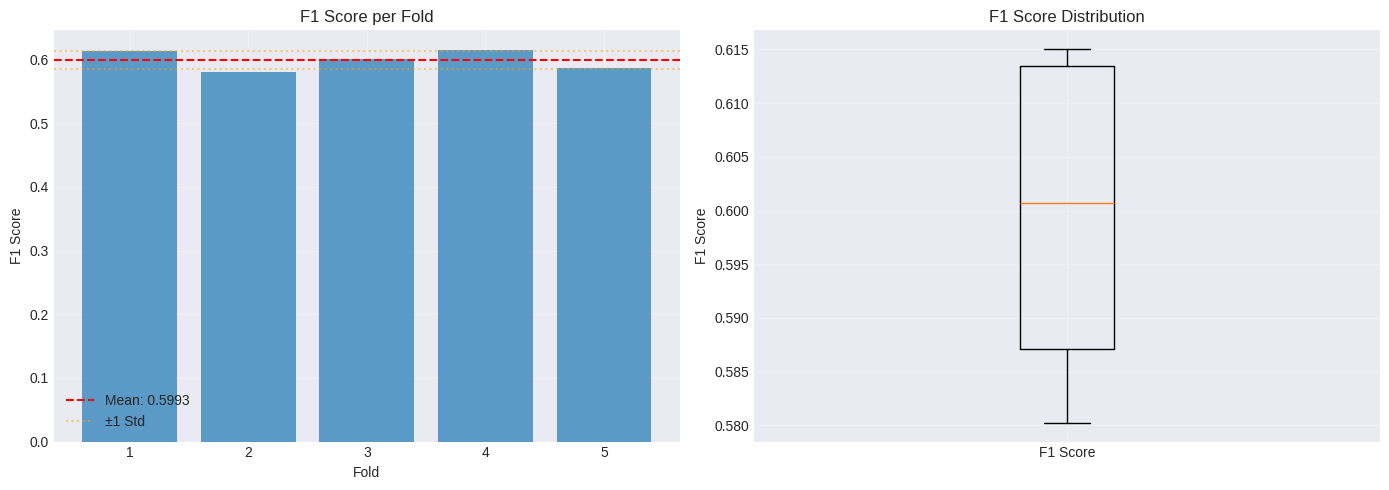


INTERPRETATION
📊 NOTE: We are optimizing for F1 SCORE (primary metric)
   Other metrics (ROC AUC, PR AUC, Accuracy) are shown for reference

Fixed Hyperparameters (0.5 threshold):     F1 = 0.5438
Optuna Tuned + Threshold (single split):  F1 = 0.5819
5-Fold CV Mean F1:                           F1 = 0.5993
5-Fold CV Mean Accuracy:                     0.7862

✅ Moderate variance (0.0139) - model is reasonably stable

🎯 Expected Leaderboard F1: 0.5993 ± 0.0139

✅ K-FOLD CROSS-VALIDATION COMPLETE

Review the CV results above. If performance is satisfactory, proceed to train final model.
If not, consider adjusting hyperparameters or feature engineering.


In [37]:
print("="*80)
print("STEP 3: 5-FOLD CROSS-VALIDATION WITH BEST PARAMETERS")
print("="*80)

from sklearn.model_selection import StratifiedKFold

# Use best parameters from Optuna
print(f"\nRunning 5-Fold Cross-Validation with best parameters...")
print(f"This validates performance across 5 different train/val splits\n")

# Setup 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

fold_scores = []
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all), 1):
    print(f"Fold {fold}/5...")

    X_train_fold = X_all.iloc[train_idx]
    y_train_fold = y_all.iloc[train_idx]
    X_val_fold = X_all.iloc[val_idx]
    y_val_fold = y_all.iloc[val_idx]

    # Train model
    model_fold = lgb.LGBMClassifier(**best_params_cv)
    model_fold.fit(X_train_fold, y_train_fold)

    # Get probabilities
    y_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]

    # Optimize threshold for this fold
    thresholds = np.arange(0.25, 0.76, 0.01)
    best_f1_fold = 0
    best_thresh_fold = 0.5

    for thresh in thresholds:
        preds = (y_proba_fold >= thresh).astype(int)
        f1 = f1_score(y_val_fold, preds)
        if f1 > best_f1_fold:
            best_f1_fold = f1
            best_thresh_fold = thresh

    # Calculate metrics with optimal threshold
    y_pred_fold = (y_proba_fold >= best_thresh_fold).astype(int)

    f1 = f1_score(y_val_fold, y_pred_fold)
    roc = roc_auc_score(y_val_fold, y_proba_fold)
    pr = average_precision_score(y_val_fold, y_proba_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)
    accuracy = (y_pred_fold == y_val_fold).mean()  # Add accuracy

    fold_scores.append(f1)  # We optimize for F1 score
    fold_results.append({
        'Fold': fold,
        'F1': f1,  # PRIMARY METRIC - This is what we optimize for
        'ROC_AUC': roc,
        'PR_AUC': pr,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'Optimal_Threshold': best_thresh_fold
    })

    print(f"  F1: {f1:.4f} | ROC: {roc:.4f} | PR: {pr:.4f} | Accuracy: {accuracy:.4f} | Threshold: {best_thresh_fold:.3f}")

# Calculate statistics
mean_f1 = np.mean(fold_scores)
std_f1 = np.std(fold_scores)
min_f1 = np.min(fold_scores)
max_f1 = np.max(fold_scores)

print(f"\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)
results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Mean F1:      {mean_f1:.4f}")
print(f"Std F1:       {std_f1:.4f}")
print(f"Min F1:       {min_f1:.4f}")
print(f"Max F1:       {max_f1:.4f}")
print(f"95% CI:       [{mean_f1 - 1.96*std_f1:.4f}, {mean_f1 + 1.96*std_f1:.4f}]")

# Calculate average optimal threshold across folds
avg_optimal_threshold = np.mean(results_df['Optimal_Threshold'])
print(f"\nAverage Optimal Threshold: {avg_optimal_threshold:.3f}")

# Visualize CV results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 score per fold
axes[0].bar(range(1, 6), fold_scores, alpha=0.7)
axes[0].axhline(y=mean_f1, color='r', linestyle='--', label=f'Mean: {mean_f1:.4f}')
axes[0].axhline(y=mean_f1 + std_f1, color='orange', linestyle=':', alpha=0.5, label=f'±1 Std')
axes[0].axhline(y=mean_f1 - std_f1, color='orange', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score per Fold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 score distribution
axes[1].boxplot(fold_scores, labels=['F1 Score'])
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("📊 NOTE: We are optimizing for F1 SCORE (primary metric)")
print("   Other metrics (ROC AUC, PR AUC, Accuracy) are shown for reference\n")

if 'f1_fixed' in locals():
    print(f"Fixed Hyperparameters (0.5 threshold):     F1 = {f1_fixed:.4f}")
if 'best_f1_thresh' in locals():
    print(f"Optuna Tuned + Threshold (single split):  F1 = {best_f1_thresh:.4f}")
print(f"5-Fold CV Mean F1:                           F1 = {mean_f1:.4f}")

# Calculate average accuracy across folds
avg_accuracy = np.mean(results_df['Accuracy'])
print(f"5-Fold CV Mean Accuracy:                     {avg_accuracy:.4f}")

if std_f1 < 0.01:
    print(f"\n✅ Low variance ({std_f1:.4f}) - model is STABLE!")
elif std_f1 < 0.02:
    print(f"\n✅ Moderate variance ({std_f1:.4f}) - model is reasonably stable")
else:
    print(f"\n⚠️  High variance ({std_f1:.4f}) - model performance varies by data split")

print(f"\n🎯 Expected Leaderboard F1: {mean_f1:.4f} ± {std_f1:.4f}")

print("\n" + "="*80)
print("✅ K-FOLD CROSS-VALIDATION COMPLETE")
print("="*80)
print("\nReview the CV results above. If performance is satisfactory, proceed to train final model.")
print("If not, consider adjusting hyperparameters or feature engineering.")


# predicting


In [39]:
print("="*80)
print("STEP 4: FINAL MODEL - TRAINING ON 100% DATA")
print("="*80)

# We are using the variables from your previous cells:
# - X_all, y_all: Full training data (17999, 158)
# - X_test_all: Full test data (12000, 158)
# - best_lgbm_params: The dictionary of best params from your Optuna run
# - optimal_threshold_f1: The best F1 threshold you found (e.g., 0.43)

print(f"\nTraining final model on full dataset: {X_all.shape[0]} samples...")
print(f"Using best parameters from Optuna and optimal threshold={optimal_threshold_f1:.3f}")

# Ensure columns are strings for LGBM
X_all.columns = X_all.columns.astype(str)
X_test_all.columns = X_test_all.columns.astype(str)

# Train the final model on ALL data
lgb_final_model = lgb.LGBMClassifier(**best_lgbm_params)
lgb_final_model.fit(X_all, y_all)

print("✓ Final model trained on 100% of data.")

# --- Generate predictions for test set ---
print("\nGenerating predictions on test set...")

# Ensure test columns match train columns
X_test_all = X_test_all[X_all.columns]
test_probas = lgb_final_model.predict_proba(X_test_all)[:, 1]

# Apply the optimal threshold found earlier
test_predictions_final = (test_probas >= optimal_threshold_f1).astype(int)

print(f"✓ Test predictions generated using threshold={optimal_threshold_f1:.3f}")

# --- Create Submission CSV ---
submission_df = pd.DataFrame({
    'claim_number': test_ids,
    'subrogation': test_predictions_final
})

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print("\n" + "="*80)
print("SUBMISSION FILE CREATED")
print("="*80)
print(f"✓ File saved as: {submission_filename}")

print("\nFinal prediction distribution:")
print(submission_df['subrogation'].value_counts(normalize=True).to_string())

# Optional: Download if in Colab
try:
    import google.colab
    from google.colab import files
    files.download(submission_filename)
    print(f"\n✓ Downloading {submission_filename}...")
except ImportError:
    print(f"\n✓ Script complete. Find your file at: {submission_filename}")



STEP 4: FINAL MODEL - TRAINING ON 100% DATA

Training final model on full dataset: 17999 samples...
Using best parameters from Optuna and optimal threshold=0.610
✓ Final model trained on 100% of data.

Generating predictions on test set...
✓ Test predictions generated using threshold=0.610

SUBMISSION FILE CREATED
✓ File saved as: submission.csv

Final prediction distribution:
subrogation
0   0.724
1   0.276


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Downloading submission.csv...
